In [1]:
# This tutorial will briefly show the how to build a DMDc model from the aerodynamic data.
# We will create the database, create the physical model, and finally use them to obtain the ROM.
# We will then plot the eigenvalues of the aerodynamic system, to study how the system evolve.
# After the completion of this tutorial you should be able to obtain a surrogate model from high-fidelity
# aerodynamics, that can be used to reproduce and interpret the full-simulation

In [2]:
# We will assume the completion of tutorial 1 in the following. Here we call the main functions of tutorial 1 that
# are required to proceed

import os
os.chdir("..")
import aerodynamics
os.chdir("Tutorials")

stru_history = "data/blendedStep/StructHistoryModal.dat"
aero_history = "data/blendedStep/surface_flow.csv"

database = aerodynamics.database(stru_history,aero_history)
model = aerodynamics.physicalModel("data/Modes/Normals.csv","data/Modes/Mode.csv")



Creating the database for the reduced order model.
Importing the data from the files.
Opened structural history file data/blendedStep/StructHistoryModal.dat.
Completed reading
Starting the reading of surface_flow.csv files.
Opened time iter 1099 last time iter is 1099
Completed reading
Done
Creating the physical model.
Importing the data from the files.
Obtaining the normals to the different panels.
Completed reading
Obtaining the mode shapes
Starting with the undeformed condition
Obtain now the deformation due to modes
Opened file 1 of 2
Opened file 2 of 2
Completed reading
Done


In [4]:
# The creation of the rom is a simple one-line statement. 
rom = aerodynamics.ROM(database, model)
# This contains the matrices A and B that are used
# to advance the system in time following x^n+1 = Ax^n + Bu^n

In [5]:
# We can now perform an eigenvalue analysis of the A matrix to obtain the DMD aerodynamic modes.
import numpy as np
w, v = np.linalg.eig(rom.A)

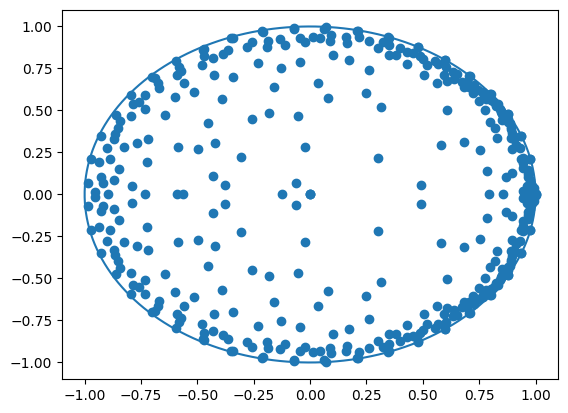

In [6]:
# It is of great interest to capture the first modes and their eigenvalues, to understand the physics
import matplotlib.pyplot as plt
import math
plt.scatter(w.real,w.imag)

# The system stability is determined by the eigenvalues, they should be inside the unit circle
theta = np.linspace(0,2*math.pi,200)
x = np.cos(theta)
y = np.sin(theta)
plt.plot(x,y)

np.savetxt('eigenvaluesTutorial2.csv', w, delimiter=',')

In [7]:
# The first sanity check that we can perform is to reproduce the training data

lift = np.empty((0))
aeroState = np.empty((database.X.shape[0], 0))
# Then we iterate for the number of total time iterations, providing to the rom the same inputs of the full model
from sys import stdout
for i in range(len(database.timeIter)):
    stdout.write("\rTime iteration " + str(i+1) + " of " + str(len(database.timeIter)))
    stdout.flush()
    
    # With the predict function we compute the new time level aerodynamic state. It also provides as input the corresponding
    # modal forces. It receives as input the structural modal amplitudes.
    aeroState = np.append(aeroState, rom.predict(database.U[:,i], database.Udot[:,i], 
                                                 database.Uddot[:,i]).reshape(database.X.shape[0], 1) -
                                     rom.Xcenter, axis=1)
    aeroLift = rom.getLift()
    
    # We can also access the new state as rom.X. Please remember that this is the reduced state, thus in order to get
    # the full one we must multiply for the PODs of the physical state and add the mean flow.
    # If we directly pass this full state to the physical model we can again obtain the lift.
    lift = np.append(lift, model.getLift(rom.Z))
    
    # With the update function, we advance the state inside the class ROM
    rom.update()

stdout.write("\rCompleted time integration\n")
stdout.flush()

    
# The lift computed in the two ways is equivalent, the direct way (using the model) is only shown for explanation
# purposes. Indeed, the two lifts are (for the last state):
print("Lift 1 is {}, while Lift 2 is {}".format(aeroLift, lift[len(lift)-1]))

Time iteration 1 of 901

Completed time integration
Lift 1 is [460.99691439], while Lift 2 is 460.99691438643026


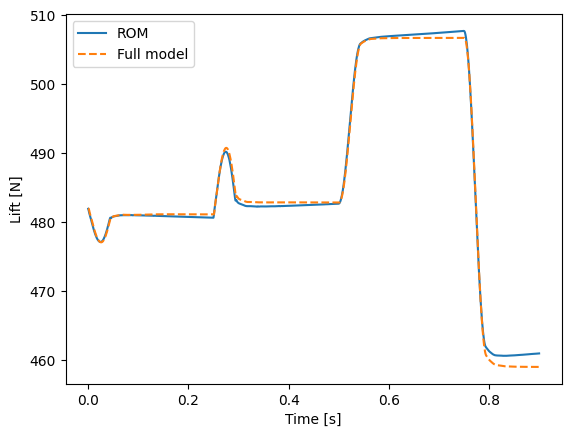

In [8]:
# We can then compute the same quantities as for tutorial 1 as a reference
lift_ref = []

for i in range(len(database.timeIter)):
    lift_ref = np.append(lift_ref, model.getLift(database.X[:,i]))

plt.plot(0.001*np.linspace(0, len(database.timeIter)-1, len(database.timeIter)), lift, '-')
plt.plot(0.001*np.linspace(0, len(database.timeIter)-1, len(database.timeIter)), lift_ref, '--')
# just make the plot pretty
plt.xlabel("Time [s]")
plt.ylabel("Lift [N]")
plt.legend(["ROM","Full model"])

np.savetxt('liftTutorial2.csv', lift, delimiter=',')
np.savetxt('lift_refTutorial2.csv', lift_ref, delimiter=',')

In [9]:
# We can see that the match is very nice. There is a slow drift given by a couple of unsteady egeinvalues. This must
# be solved with a stabilisation procedure, discussed in the following tutorial.

(-100.0, 100.0)

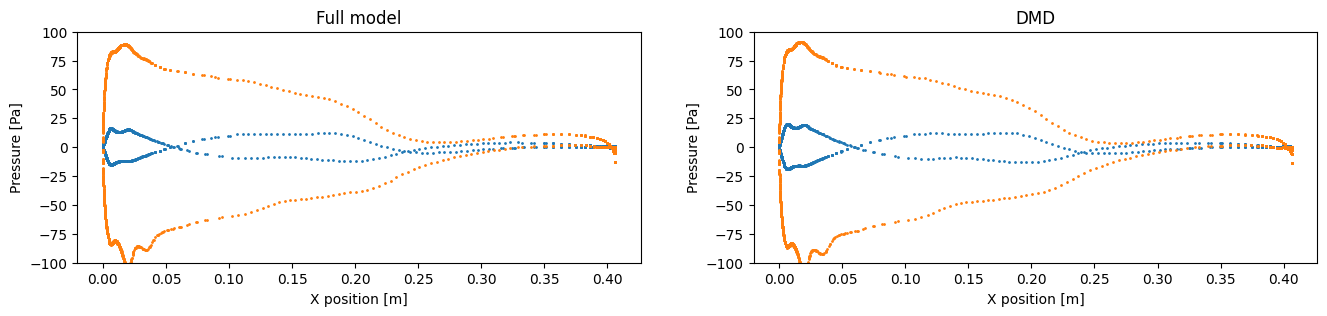

In [10]:
# It is also of interest to understand if not only we can reproduce the global performance indices, like the lift,
# but also the microscopic behaviour, as the pressure distribution. This is of paramount importance as most of the
# model available at the moment, like ARMAX, MIMO ARMAX, Impulse transfer function analysis, they all focus on the
# surrogate modeling of the input-output relation, missing the state evolution details. With our models, you are able
# to study the details of pressure behaviour, that eventually leads to the global performance indices.

# We will only plot the unsteady part of pressure, as this is the one that we compute with DMD

# The data we want must be extracted for a y value of 0.1 m
# We first find the index of time step 700 and 730
index700 = database.timeIter == 700
index730 = database.timeIter == 730

# We now extract the vertices close to y = 0.1 m (1 cm close)
undeformedx = np.empty((0))
undeformedy = np.empty((0))
for i in range(len(model.undeformedShape)):
    undeformedx = np.append(undeformedx, model.undeformedShape[i].ux)
    undeformedy = np.append(undeformedy, model.undeformedShape[i].uy)
    
pressure_ref = database.X - rom.Xcenter
    
positionx = undeformedx[(undeformedy < 0.11) & (undeformedy > 0.09)]
pressure700_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index700]
pressure730_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index730]
pressure700 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), index700]
pressure730 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), index730]
   
plt.figure(figsize=(16,3))

# In blue we will have the distribution before pitching, in orange after

plt.subplot(1,2,1)
plt.scatter(positionx, pressure700_ref, marker='o', s=1)
plt.scatter(positionx, pressure730_ref, marker='o', s=1)
plt.xlabel("X position [m]")
plt.ylabel("Pressure [Pa]")
plt.title("Full model")
plt.ylim(-100,100)

plt.subplot(1,2,2)
plt.scatter(positionx, pressure700, marker='o', s=1)
plt.scatter(positionx, pressure730, marker='o', s=1)
plt.xlabel("X position [m]")
plt.ylabel("Pressure [Pa]")
plt.title("DMD")
plt.ylim(-100,100)

# We can see that the pitch input is actually very small, but due to the transonic conditions the change the input should
# be limited to the linear region nearby the linearisation point. However, the DMD model can actually represent very nicely
# the pressure distribution, which is a novelty in the field.
# The drift observed before infuence the behaviour as we see a sligtly higher ampltidues of pressure variation, due to the
# pitch. However, this will be solved with the stabilisation procedure.